In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
#tf.enable_eager_execution()
#import tensorflow.contrib.eager as tfe
import sys
import os
from sklearn.utils import shuffle
from random import sample
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
# import copy
# import re
# import random
import requests

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, \
BatchNormalization, GlobalAveragePooling2D, Conv2D
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.applications.inception_v3 import decode_predictions
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.python.keras.utils import plot_model
#from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15006362154644533052
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18049475661707143300
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9847116140642283816
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11156886682864884526
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15704447386
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5891114215147710005
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15704447386
locality {
  bus_id: 1
  links {
  }
}
incarnation: 

In [6]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
print(tf.test.is_built_with_cuda())

True


# Doanload Data

In [4]:
PATH = '/mnt/disk1'

In [10]:
annotation_zip = tf.keras.utils.get_file('annotations.zip',
                                          cache_subdir=PATH + '/data/',
                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/labels/caltech_images_20190919.json.zip',
                                          extract = True)

In [ ]:
image_zip = tf.keras.utils.get_file('images.zip',
                                          cache_subdir=PATH+'/data/',
                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/cct_images.tar.gz',
                                          extract = True)

 81702789120/112540764160 [====================>.........] - ETA: 21:27

In [13]:
# annotation_zip

'/home/c_weiwei_cao/crow/data/annotations.zip'

In [14]:
# image_zip

'/home/c_weiwei_cao/crow/data/images.zip'

# Prepare Data for Modeling

In [5]:
# get data from json
with open(PATH + "/data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')], axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [17]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = PATH + '/data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= PATH + '/data/cct_images/'+image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

deer 598497f9-23d2-11e8-a6a3-ec086b02610b


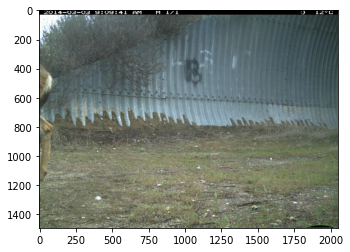

deer 59be405c-23d2-11e8-a6a3-ec086b02610b


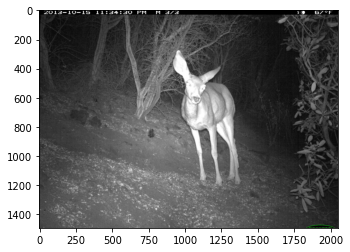

deer 58732d7d-23d2-11e8-a6a3-ec086b02610b


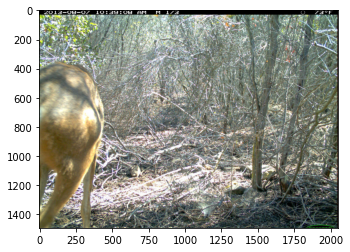

In [19]:
show_image_by_category(3, 'deer')

In [44]:
# id = 102113
# show_image(img_path_vector[id], cat_name_vector[id])

# Split Data by Location

In [6]:
# download suggested split from data website
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()

# use suggested split for test
train_val_loc = sorted(list(set(split['splits']['train'])))
test_loc = sorted(list(set(split['splits']['val'])))

In [7]:
# furthur split training and validation
train_val_loc = shuffle(train_val_loc, random_state=2)
train_loc = train_val_loc[:80]
val_loc = train_val_loc[80:]

In [22]:
len(train_val_loc)

100

In [23]:
len(test_loc)

40

In [8]:
# how many images are in each split?
train_dist = image_df_annot[image_df_annot['location'].isin(train_loc)].groupby('category_name').image_id.count().sort_values()
val_dist = image_df_annot[image_df_annot['location'].isin(val_loc)].groupby('category_name').image_id.count().sort_values()
test_dist = image_df_annot[image_df_annot['location'].isin(test_loc)].groupby('category_name').image_id.count().sort_values()

train_img = image_df_annot[image_df_annot['location'].isin(train_loc)].image_id.count()
val_img = image_df_annot[image_df_annot['location'].isin(val_loc)].image_id.count()
test_img = image_df_annot[image_df_annot['location'].isin(test_loc)].image_id.count()

print(len(train_loc))
print(len(val_loc))
print(len(test_loc))

print('train: ' + str(train_img))
print('val: ' + str(val_img))
print('test: ' + str(test_img))

80
20
40
train: 144526
val: 36164
test: 62410


### Define prediction classes

In [9]:
classes = ['rodent','squirrel','rabbit','bird','deer','raccoon','skunk','opossum']
classes_dict = dict(zip(classes + ['other'] + ['empty'], range(10)))
classes_dict_lookup = dict(zip(range(10), classes + ['other'] + ['empty']))

In [10]:
classes_dict

{'rodent': 0,
 'squirrel': 1,
 'rabbit': 2,
 'bird': 3,
 'deer': 4,
 'raccoon': 5,
 'skunk': 6,
 'opossum': 7,
 'other': 8,
 'empty': 9}

In [11]:
orig_class = list(image_df_annot['category_name'].unique())
new_class = [animal if animal in classes + ['empty'] else 'other' for animal in orig_class]
prediction_class_map = dict(zip(orig_class, new_class))

In [12]:
prediction_class_map

{'empty': 'empty',
 'rabbit': 'rabbit',
 'bobcat': 'other',
 'squirrel': 'squirrel',
 'raccoon': 'raccoon',
 'coyote': 'other',
 'bird': 'bird',
 'car': 'other',
 'opossum': 'opossum',
 'cow': 'other',
 'skunk': 'skunk',
 'dog': 'other',
 'deer': 'deer',
 'fox': 'other',
 'cat': 'other',
 'rodent': 'rodent',
 'mountain_lion': 'other',
 'lizard': 'other',
 'badger': 'other',
 'insect': 'other',
 'pig': 'other',
 'bat': 'other'}

In [13]:
image_df_annot['category_name_model'] = image_df_annot['category_name'].map(prediction_class_map)
image_df_annot['category_id_model'] = image_df_annot['category_name'].map(classes_dict)
image_df_annot = image_df_annot.sample(frac=1, random_state=1)

In [14]:
image_df_annot.groupby('category_name_model').image_id.count().sort_values()

category_name_model
skunk         1892
rodent        4272
squirrel      4432
bird          9521
raccoon      10981
deer         12191
rabbit       12345
opossum      16634
other        45087
empty       125745
Name: image_id, dtype: int64

### Data Partition

In [15]:
data_train = image_df_annot[image_df_annot['location'].isin(train_loc)]
data_val = image_df_annot[image_df_annot['location'].isin(val_loc)]
data_test = image_df_annot[image_df_annot['location'].isin(test_loc)]

In [16]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(144526, 15)
(36164, 15)
(62410, 15)


In [17]:
# get image vector
img_vector_train = list(PATH + '/data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list(PATH + '/data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list(PATH + '/data/cct_images/' + data_test['image_id'] + '.jpg')

In [18]:
# get category vector
cat_name_vector_train = list(data_train['category_name_model'])
cat_id_vector_train = list(data_train['category_id_model'])

cat_name_vector_val = list(data_val['category_name_model'])
cat_id_vector_val = list(data_val['category_id_model'])

cat_name_vector_test = list(data_test['category_name_model'])
cat_id_vector_test = list(data_test['category_id_model'])

Category: empty


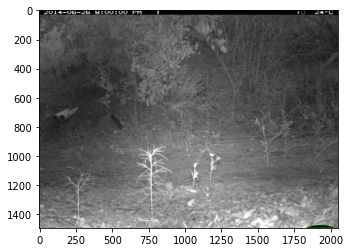

In [40]:
id = 5
show_image(img_vector_train[id], cat_name_vector_train[id])

# Encode Images with InceptionV3 For Faster Training

In [19]:
# Get the InceptionV3 model trained on imagenet data
inception_v3 = InceptionV3(weights='imagenet')

# Take -3 layer with shape (8,8,2048)
inception_v3_body = Model(inception_v3.input, inception_v3.layers[-3].output)

In [20]:
inception_v3_body.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 8, 8, 2048) dtype=float32>

In [21]:
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

In [23]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_train)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','train')
        np.save(path_of_feature, bf.numpy())
        
# 53513 images, 64 batch size, expect 837 batches

1506it [06:22,  3.94it/s]


In [24]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_val)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','val')
        np.save(path_of_feature, bf.numpy())
        
# 31182 images, 64 batch size, expect 488 batches

377it [01:35,  3.94it/s]


In [25]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_test)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(96)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 43435 images, 64 batch size, expect 679 batches

651it [03:37,  3.00it/s]


### redo the ones that were not in the old data

In [115]:
img_vector_old = img_vector_train_old + img_vector_val_old + img_vector_test_old
img_vector_new = img_vector_train + img_vector_val + img_vector_test

In [116]:
print(len(img_vector_old))
print(len(img_vector_new))

128130
243100


In [117]:
img_vector_redo = list(set(img_vector_new) - set(img_vector_old))
print(len(img_vector_redo))

114970


In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_redo)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 114970 images, 64 batch size, expect 1797 batches

178it [12:10,  4.15s/it]

In [47]:
image_dataset

AttributeError: 'BatchDataset' object has no attribute 'head'

# Try using InceptionV3 without re-training to run inference on our data

In [46]:
print("model structure: ", inception_v3.summary())
#print("model weights: ", model.get_weights())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

[[('n02325366', 'wood_rabbit', 0.76865214), ('n02326432', 'hare', 0.0504399), ('n03388043', 'fountain', 0.02028747)]]


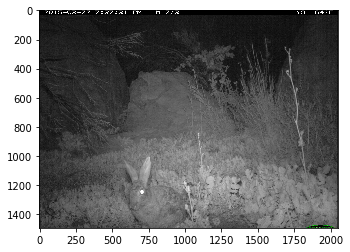

In [102]:
img_path = img_vector_train[14]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = inception_v3.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

[[('n01580077', 'jay', 0.72900456), ('n01806567', 'quail', 0.028316636), ('n01537544', 'indigo_bunting', 0.026563805)]]


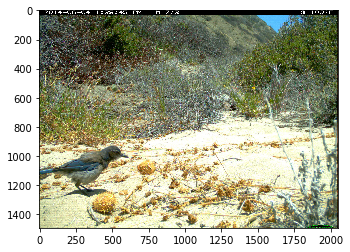

In [108]:
img_path = img_vector_train[18]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = inception_v3.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

[[('n02423022', 'gazelle', 0.78349143), ('n02422699', 'impala', 0.05957584), ('n02415577', 'bighorn', 0.04937292)]]


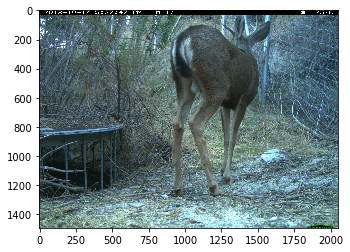

In [103]:
img_path = img_vector_train[9]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = inception_v3.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

# Transfer learning with InceptionV3 - train last layer - baseline model

In [21]:
# take InceptionV3 without last layer
model_transfer = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [28]:
# freeze all weights
for layer in model_transfer.layers:
    layer.trainable = False

In [29]:
# add new trainable last layer and build model
x = model_transfer.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.2)(x)
x = Dense(15, activation="softmax")(x)
model = Model(model_transfer.input, x)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [30]:
# compile model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

### Use encoded values

In [38]:
# add new trainable last layer and build model
transfer_input = Input(shape=(8,8,2048))
#x = Conv2D(1024, (3, 3), padding='same', activation='relu')(transfer_input)
#x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(transfer_input)
x = Dropout(0.2)(x)
#x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
#x = BatchNormalization()(x)
x = Dense(15, activation="softmax")(x)
model = Model(transfer_input, x)

In [39]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_9 (Dense)              (None, 15)                3855      
Total params: 528,399
Trainable params: 528,399
Non-trainable params: 0
_________________________________________________________________


In [80]:
# compile model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

### Preprocess images and generator function

In [24]:
def load_image(path):
    img = Image.open(path)
    img = img.resize(size=(299,299), resample=Image.LANCZOS).convert("RGB")
    img = np.array(img)
    img = img / 255.0
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

In [25]:
def load_encoding(path):
    return np.load(path.replace('cct_images', 'test') + '.npy')

In [26]:
def generator(X_data, y_data, batch_size):
    i = 0
    while True:
        X_batch = []
        y_batch = []
        
        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = X_data[i]
            y = y_data[i]
            X = load_image(X)
            X_batch.append(X)
            y_batch.append(y)
            i += 1
            
        yield np.array(X_batch), np.array(y_batch)

In [27]:
def generator_encoded(X_data, y_data, batch_size):
    i = 0
    while True:
        X_batch = []
        y_batch = []
        
        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = load_encoding(X_data[i])
            y = y_data[i]
            X_batch.append(X)
            y_batch.append(y)
            i += 1
            
        yield np.array(X_batch), np.array(y_batch)

In [54]:
# sample_x_train = tf.data.Dataset.from_tensor_slices(img_vector_train[:1024])
# sample_x_train = sample_x_train.map(load_image_for_inception, 
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [76]:
# test on 1024 images
sample_x_train = img_vector_train[:2048]
sample_y_train = cat_id_vector_train[:2048]

sample_x_val = img_vector_val[:64]
sample_y_val = cat_id_vector_val[:64]

In [85]:
# train model with encoded data - much faster
# sample data
# EPOCH = 10
# BATCH_SIZE = 64
# TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
# VAL_STEPS = len(sample_x_val)//BATCH_SIZE

# train_generator = generator_encoded(sample_x_train, sample_y_train, BATCH_SIZE)
# val_generator = generator_encoded(sample_x_val, sample_y_val, BATCH_SIZE)

# for i in range(EPOCH):
#     model.fit_generator(generator=train_generator, \
#                         validation_data=val_generator,\
#                         validation_steps=VAL_STEPS, \
#                         steps_per_epoch=TRAIN_STEPS, \
#                         epochs=1, verbose=1,\
#                         use_multiprocessing=True)
#     model.save('./weights/baseline/model_' + str(i) + '.h5')

In [83]:
# train model with encoded data - much faster
# full data
EPOCH = 10
BATCH_SIZE = 64
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE)
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE)

for i in range(EPOCH):
    model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        use_multiprocessing=True)
    model.save('./weights/model_1/model_' + str(i) + '.h5')

836/836 [==============================] - 1174s 1s/step - loss: 0.3897 - acc: 0.8736 - val_loss: 3.4603 - val_acc: 0.3792


In [35]:
# train model
EPOCH = 3
BATCH_SIZE = 16
TRAIN_STEPS = len(sample_x_train)//BATCH_SIZE
VAL_STEPS = len(sample_y_train)//BATCH_SIZE

train_generator = generator(sample_x_train, sample_y_train, BATCH_SIZE)
val_generator = generator(sample_x_val, sample_y_val, BATCH_SIZE)

for i in range(EPOCH):
    model.fit_generator(generator=train_generator, \
                                    validation_data=val_generator,\
                                    validation_steps=VAL_STEPS, \
                                    steps_per_epoch=TRAIN_STEPS, \
                                    epochs=1, verbose=2)
    model.save('./weights/baseline/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8/8 - 18s - loss: 2.4980 - acc: 0.2344
8/8 - 67s - loss: 2.6263 - acc: 0.1641 - val_loss: 2.4980 - val_acc: 0.2344
8/8 - 16s - loss: 2.5113 - acc: 0.2812
8/8 - 64s - loss: 2.0461 - acc: 0.3438 - val_loss: 2.5113 - val_acc: 0.2812
8/8 - 16s - loss: 2.5819 - acc: 0.3125
8/8 - 64s - loss: 1.7460 - acc: 0.5078 - val_loss: 2.5819 - val_acc: 0.3125


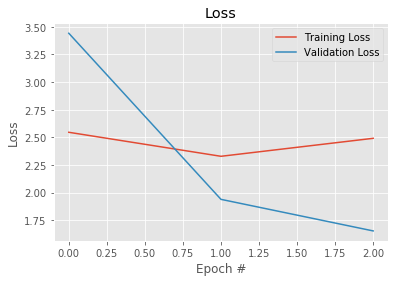

In [37]:
# Plot loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 3), history.history['val_loss'], label='Training Loss')
plt.plot(np.arange(0, 3), history.history['loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [84]:
#print("model weights: ", model.get_weights())

In [111]:
prediction = model.predict(load_encoding(img_vector_val[8]).reshape(1, 8, 8, 2048))
classes_dict_lookup[prediction.argmax()]

'deer'

In [100]:
prediction

array([[1.00493516e-10, 9.99313488e-06, 6.80500989e-08, 1.88398717e-05,
        6.23600727e-09, 1.09231763e-03, 7.13733898e-04, 8.44596606e-03,
        1.34779601e-12, 7.04586744e-01, 1.88892648e-06, 9.46996297e-05,
        2.64808297e-01, 1.54517795e-04, 2.00729556e-02]], dtype=float32)

Category: deer


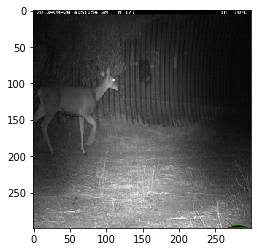

In [110]:
id = 8
show_image(img_vector_val[id], classes_dict_lookup[cat_id_vector_val[id]])

# Prediction on Test Set

In [128]:
predicted_id = []
predicted_name = []
for i in img_vector_test:
    pred_id = model.predict(load_encoding(i).reshape(1, 8, 8, 2048))
    pred_name = classes_dict_lookup[pred_id.argmax()]
    predicted_id.append(pred_id)
    predicted_name.append(pred_name)

# save prediction
with open('data/predicted_id.pkl', 'wb') as f:
    pickle.dump(predicted_id, f)
with open('data/predicted_name.pkl', 'wb') as f:
    pickle.dump(predicted_name, f)

In [129]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='macro')
evaluation2 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='weighted')

/home/c_weiwei_cao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
print(evaluation1)
print(evaluation2)

(0.2817287060077009, 0.3150333397446097, 0.2782089974744629, None)
(0.3248084690703974, 0.31184528605962936, 0.29707582985342407, None)


In [115]:
predicted_name

['coyote',
 'bird',
 'coyote',
 'opossum',
 'rabbit',
 'bobcat',
 'rodent',
 'raccoon',
 'opossum',
 'coyote']

In [118]:
cat_name_vector_test[:10]

['coyote',
 'rabbit',
 'cow',
 'raccoon',
 'coyote',
 'other',
 'rodent',
 'bobcat',
 'coyote',
 'other']

Category: other


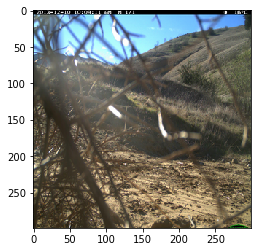

In [127]:
id = 9
show_image(img_vector_test[id], classes_dict_lookup[cat_id_vector_test[id]])

In [112]:
img_vector_test[0]

'data/cct_images/59439fd8-23d2-11e8-a6a3-ec086b02610b.jpg'

In [116]:
cat_name_vector_test[0]

'coyote'

In [117]:
cat_id_vector_test[0]

12

# Combine Model

In [29]:
x = model_transfer.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dense(15, activation="softmax")(x)
model_combined = Model(model_transfer.input, x)

In [45]:
model_combined.load_weights('weights/combined/combined_model.h5')

In [46]:
model_combined.get_weights()

[array([[[[-4.59105551e-01, -4.14526574e-02, -3.62577499e-03,
           -9.87672508e-02, -3.37070860e-02,  4.79929037e-02,
            2.32542142e-01,  3.23927671e-01,  5.90160079e-02,
            9.47738215e-02,  4.24996056e-02,  1.26620471e-01,
            1.33215979e-01,  1.22741833e-01, -7.92686343e-02,
            2.08227970e-02, -1.99647829e-01, -3.02687973e-01,
           -2.10659921e-01, -3.52898419e-01, -5.58023095e-01,
            3.20223093e-01,  4.53596050e-03, -3.09266411e-02,
           -6.86957911e-02,  2.00968519e-01,  1.14542745e-01,
            2.40372881e-01,  1.52943470e-02,  5.96231259e-02,
           -5.85714653e-02,  8.78173351e-01],
          [ 3.16376328e-01, -4.78494260e-03, -6.84681814e-03,
            7.44503662e-02, -1.97458476e-01,  5.20143658e-02,
           -1.24460436e-01,  3.36123914e-01,  3.01678218e-02,
           -1.26477107e-01, -1.05597451e-01, -5.31241074e-02,
           -2.43102223e-01,  1.66047230e-01, -1.03186309e-01,
           -6.55613691e-

In [51]:
img_vector_test[0]

'data/cct_images/59439fd8-23d2-11e8-a6a3-ec086b02610b.jpg'

In [47]:
pred_id_list = []
pred_name_list = []
for i in img_vector_test[:10]:
    predicted_id_test = model_combined.predict(load_image(i).reshape(1, 299, 299, 3))
    predicted_name_test = classes_dict_lookup[predicted_id_test.argmax()]
    pred_id_list.append(predicted_id_test)
    pred_name_list.append(predicted_name_test)

In [48]:
pred_name_list

['coyote',
 'bird',
 'coyote',
 'bird',
 'rabbit',
 'bird',
 'bird',
 'coyote',
 'rabbit',
 'coyote']

In [ ]:
predicted_name
['coyote',
 'bird',
 'coyote',
 'opossum',
 'rabbit',
 'bobcat',
 'rodent',
 'raccoon',
 'opossum',
 'coyote']
cat_name_vector_test[:10]
['coyote',
 'rabbit',
 'cow',
 'raccoon',
 'coyote',
 'other',
 'rodent',
 'bobcat',
 'coyote',
 'other']

# Scratch Paper

In [143]:
weights = model_transfer.get_weights()
weights_new = model.get_weights()
weights_combined = weights + weights_new
model_combined.set_weights(weights_combined)
model_combined.save('./weights/combined/combined_model.h5')

380

In [10]:
loc = image_df_annot['location'].unique()
loc.sort()

In [11]:
loc

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [12]:
loc2 = image_df_annot.groupby(['location', 'category_name']).image_id.count()

In [13]:
loc2.reset_index().sort_values(by=['location','category_name'])
loc3 = pd.DataFrame(loc2).reset_index()

In [14]:
loc3.head()

,location,category_name,image_id
0,0,badger,6
1,0,bird,10
2,0,bobcat,124
3,0,car,1066
4,0,coyote,304


In [118]:
loc_pivot = loc3.pivot(index='location', columns='category_name', values='image_id')

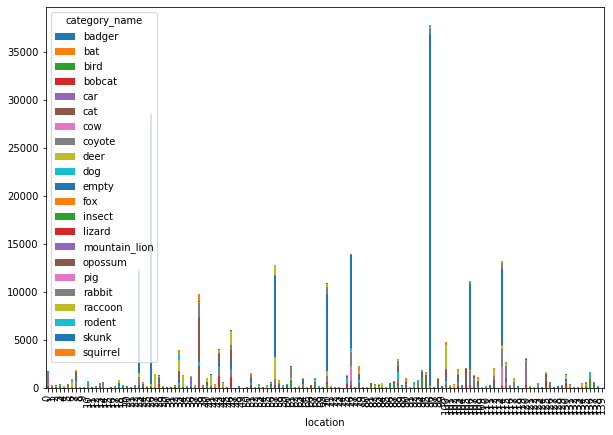

In [90]:
loc_pivot.plot.bar(stacked=True, figsize=(10,7))

In [12]:
train_dist 
#/ train_img

category_name
pig                  2
bat                  3
insect               6
badger              11
cow                 42
lizard              94
mountain_lion       97
dog                833
skunk              896
fox               1090
rodent            1583
bobcat            2059
raccoon           2073
squirrel          2291
cat               2742
car               2839
bird              4771
deer              4876
opossum           6652
coyote            6716
rabbit            8458
empty            67078
Name: image_id, dtype: int64

In [13]:
val_dist 
#/ val_img

category_name
badger              12
mountain_lion       33
lizard              44
car                292
skunk              406
cat                722
squirrel           728
fox                787
rodent            1397
rabbit            2016
dog               2048
bobcat            2222
bird              2549
raccoon           3315
opossum           3327
deer              3335
coyote            3470
empty            38775
Name: image_id, dtype: int64

In [14]:
test_dist 
#/ test_img

category_name
mountain_lion       15
badger              20
lizard             171
skunk              590
fox                697
rodent            1292
dog               1314
squirrel          1413
car               1586
cat               1703
rabbit            1871
bird              2201
cow               3584
bobcat            3671
deer              3980
raccoon           5593
coyote            6162
opossum           6655
empty            19892
Name: image_id, dtype: int64

### Cap the empty class to the highest non-empty class (OLD)

In [75]:
classes = ['skunk','fox','rodent','dog','squirrel','cat','rabbit','bird','cow','bobcat','deer','raccoon','coyote','opossum']

classes_dict = dict(zip(classes + ['other'], range(15)))
classes_dict_lookup = dict(zip(range(15), classes + ['other']))

In [76]:
classes_dict

{'skunk': 0,
 'fox': 1,
 'rodent': 2,
 'dog': 3,
 'squirrel': 4,
 'cat': 5,
 'rabbit': 6,
 'bird': 7,
 'cow': 8,
 'bobcat': 9,
 'deer': 10,
 'raccoon': 11,
 'coyote': 12,
 'opossum': 13,
 'other': 14}

In [77]:
#image_df_annot.groupby('category_name').image_id.count().sort_values()

# classes we are interested in
data_keep = image_df_annot[image_df_annot['category_name'].isin(classes)]

# sample 16000 other classes
data_other = image_df_annot[~image_df_annot['category_name'].isin(classes)].sample(n=16000, random_state=1)
data_other['category_name'] = 'other'
data_other['category_id'] = 30

# combine and shuffle
image_df_annot2 = pd.concat([data_keep, data_other]).reset_index().sample(frac=1, random_state=1)

# add class id for training
image_df_annot2['category_id_model'] = image_df_annot2['category_name'].map(classes_dict)

In [78]:
image_df_annot2.groupby('category_name').image_id.count().sort_values()

category_name
skunk        1892
fox          2574
cow          3626
dog          4195
rodent       4272
squirrel     4432
cat          5167
bobcat       7952
bird         9521
raccoon     10981
deer        12191
rabbit      12345
other       16000
coyote      16348
opossum     16634
Name: image_id, dtype: int64

### Data Partition (OLD)

In [79]:
data_train_old = image_df_annot2[image_df_annot2['location'].isin(train_loc)]
data_val_old = image_df_annot2[image_df_annot2['location'].isin(val_loc)]
data_test_old = image_df_annot2[image_df_annot2['location'].isin(test_loc)]

In [80]:
print(data_train_old.shape)
print(data_val_old.shape)
print(data_test_old.shape)

(53513, 15)
(31182, 15)
(43435, 15)


In [84]:
# get image vector
img_vector_train_old = list('data/cct_images/' + data_train_old['image_id'] + '.jpg')
img_vector_val_old = list('data/cct_images/' + data_val_old['image_id'] + '.jpg')
img_vector_test_old = list('data/cct_images/' + data_test_old['image_id'] + '.jpg')

In [85]:
# get category vector
cat_name_vector_train_old = list(data_train_old['category_name'])
cat_id_vector_train_old = list(data_train_old['category_id_model'])

cat_name_vector_val_old = list(data_val_old['category_name'])
cat_id_vector_val_old = list(data_val_old['category_id_model'])

cat_name_vector_test_old = list(data_test_old['category_name'])
cat_id_vector_test_old = list(data_test_old['category_id_model'])

Category: deer


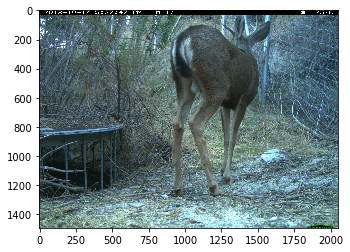

In [86]:
id = 9
show_image(img_vector_train_old[id], cat_name_vector_train_old[id])